# Part 3.2

Apply the solution in mitigating the influence of OOV words (from part 1) and train your model again

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from utils.utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data Preparation

In [2]:
BATCH_SIZE = 32
LR = 0.0001
MODEL_TYPE = "rnn"

In [3]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [4]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# load the processed embedding matrix from Part 1
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [5]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [6]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [7]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# Models

## Last State Model

In [8]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
    pooling_method="last_state"
)

In [9]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="last_state"
)

Epoch   1/100, Loss: 0.6960, Accuracy: 0.5319
Model saved.
Epoch   2/100, Loss: 0.6893, Accuracy: 0.5319
Epoch   3/100, Loss: 0.6777, Accuracy: 0.5206
Epoch   4/100, Loss: 0.5856, Accuracy: 0.7186
Model saved.
Epoch   5/100, Loss: 0.3629, Accuracy: 0.7158
Epoch   6/100, Loss: 0.2250, Accuracy: 0.7223
Model saved.
Epoch   7/100, Loss: 0.1476, Accuracy: 0.7195
Epoch   8/100, Loss: 0.0994, Accuracy: 0.7214
Epoch   9/100, Loss: 0.0687, Accuracy: 0.7073
Epoch  10/100, Loss: 0.0458, Accuracy: 0.7073
Epoch  11/100, Loss: 0.0301, Accuracy: 0.7223
Epoch  12/100, Loss: 0.0248, Accuracy: 0.7083
Epoch  13/100, Loss: 0.0194, Accuracy: 0.7045
Epoch  14/100, Loss: 0.0133, Accuracy: 0.7101
Epoch  15/100, Loss: 0.0140, Accuracy: 0.7176
Epoch  16/100, Loss: 0.0094, Accuracy: 0.7101
Early stopping triggered after 16 epochs.
Training ended, loading best model...
Model loaded.


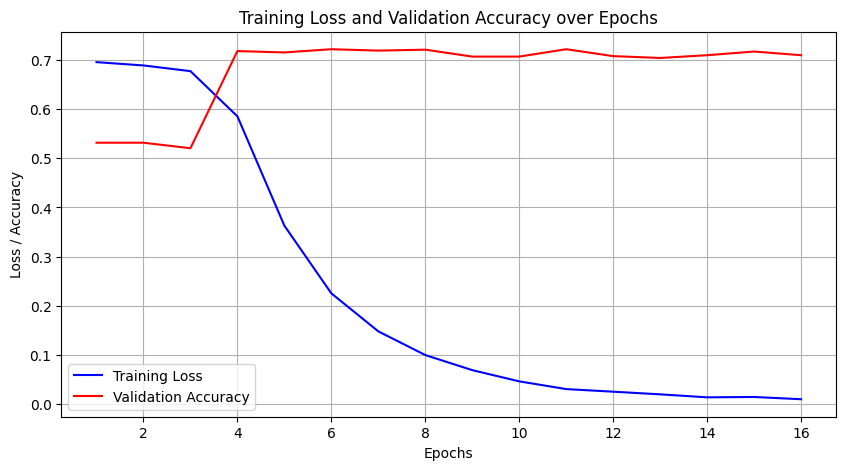

In [10]:
plot_loss_accuracy(losses, accuracies)

In [11]:
last_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7477


## Mean Pool Model

In [12]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
    pooling_method="mean_pool"
)

In [13]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_pooling"
)

Epoch   1/100, Loss: 0.6902, Accuracy: 0.6173
Model saved.
Epoch   2/100, Loss: 0.5828, Accuracy: 0.7158
Model saved.
Epoch   3/100, Loss: 0.4081, Accuracy: 0.7158
Epoch   4/100, Loss: 0.2950, Accuracy: 0.7205
Model saved.
Epoch   5/100, Loss: 0.2186, Accuracy: 0.7158
Epoch   6/100, Loss: 0.1633, Accuracy: 0.7148
Epoch   7/100, Loss: 0.1319, Accuracy: 0.7167
Epoch   8/100, Loss: 0.1018, Accuracy: 0.7073
Epoch   9/100, Loss: 0.0837, Accuracy: 0.7092
Epoch  10/100, Loss: 0.0674, Accuracy: 0.7026
Epoch  11/100, Loss: 0.0569, Accuracy: 0.7054
Epoch  12/100, Loss: 0.0455, Accuracy: 0.7045
Epoch  13/100, Loss: 0.0393, Accuracy: 0.6914
Epoch  14/100, Loss: 0.0330, Accuracy: 0.6979
Early stopping triggered after 14 epochs.
Training ended, loading best model...
Model loaded.


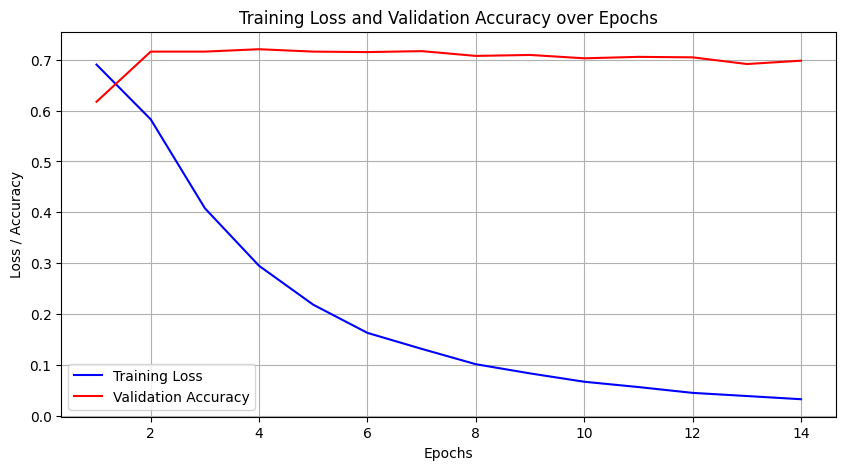

In [14]:
plot_loss_accuracy(losses, accuracies)

In [15]:
mean_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7383


## Max Pool Model

In [16]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
    pooling_method="max_pool"
)

In [17]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pooling"
)

Epoch   1/100, Loss: 0.6965, Accuracy: 0.5488
Model saved.
Epoch   2/100, Loss: 0.6843, Accuracy: 0.6013
Model saved.
Epoch   3/100, Loss: 0.6488, Accuracy: 0.6782
Model saved.
Epoch   4/100, Loss: 0.4811, Accuracy: 0.7111
Model saved.
Epoch   5/100, Loss: 0.3487, Accuracy: 0.7261
Model saved.
Epoch   6/100, Loss: 0.2635, Accuracy: 0.7176
Epoch   7/100, Loss: 0.2052, Accuracy: 0.7176
Epoch   8/100, Loss: 0.1667, Accuracy: 0.7158
Epoch   9/100, Loss: 0.1327, Accuracy: 0.7054
Epoch  10/100, Loss: 0.1097, Accuracy: 0.7129
Epoch  11/100, Loss: 0.0967, Accuracy: 0.7158
Epoch  12/100, Loss: 0.0863, Accuracy: 0.7120
Epoch  13/100, Loss: 0.0724, Accuracy: 0.6961
Epoch  14/100, Loss: 0.0654, Accuracy: 0.7036
Epoch  15/100, Loss: 0.0600, Accuracy: 0.7036
Early stopping triggered after 15 epochs.
Training ended, loading best model...
Model loaded.


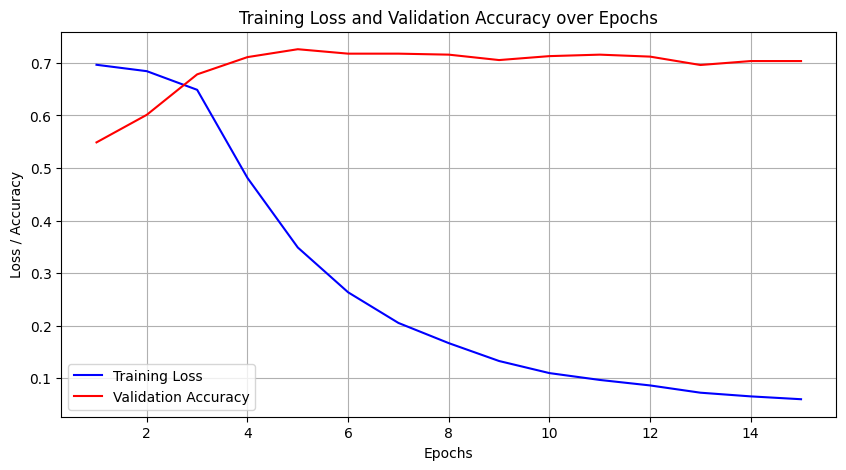

In [18]:
plot_loss_accuracy(losses, accuracies)

In [19]:
max_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7373


## Mean Max Pool Model

In [20]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
    pooling_method="mean_max"
)

In [21]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6928, Accuracy: 0.5854
Model saved.
Epoch   2/100, Loss: 0.6615, Accuracy: 0.6820
Model saved.
Epoch   3/100, Loss: 0.4816, Accuracy: 0.6961
Model saved.
Epoch   4/100, Loss: 0.3412, Accuracy: 0.7205
Model saved.
Epoch   5/100, Loss: 0.2510, Accuracy: 0.7186
Epoch   6/100, Loss: 0.1887, Accuracy: 0.7223
Model saved.
Epoch   7/100, Loss: 0.1482, Accuracy: 0.7186
Epoch   8/100, Loss: 0.1186, Accuracy: 0.7120
Epoch   9/100, Loss: 0.0938, Accuracy: 0.7111
Epoch  10/100, Loss: 0.0772, Accuracy: 0.7148
Epoch  11/100, Loss: 0.0631, Accuracy: 0.7054
Epoch  12/100, Loss: 0.0561, Accuracy: 0.7017
Epoch  13/100, Loss: 0.0483, Accuracy: 0.7073
Epoch  14/100, Loss: 0.0406, Accuracy: 0.7036
Epoch  15/100, Loss: 0.0360, Accuracy: 0.7008
Epoch  16/100, Loss: 0.0298, Accuracy: 0.7036
Early stopping triggered after 16 epochs.
Training ended, loading best model...
Model loaded.


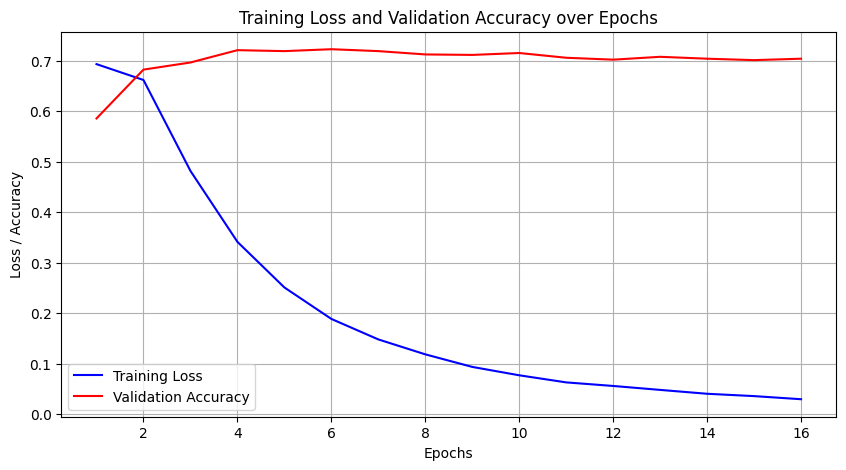

In [22]:
plot_loss_accuracy(losses, accuracies)

In [23]:
mean_max_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7364


## Attention Model

In [24]:
model = RNNModel(
    embedding_dim=350,
    hidden_size=128,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    bidirectional=False,
    num_layers=1,
    pooling_method="attention"
)

In [25]:
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6911, Accuracy: 0.5750
Model saved.
Epoch   2/100, Loss: 0.5875, Accuracy: 0.7251
Model saved.
Epoch   3/100, Loss: 0.4027, Accuracy: 0.7345
Model saved.
Epoch   4/100, Loss: 0.2901, Accuracy: 0.7167
Epoch   5/100, Loss: 0.2093, Accuracy: 0.7158
Epoch   6/100, Loss: 0.1652, Accuracy: 0.7223
Epoch   7/100, Loss: 0.1234, Accuracy: 0.7158
Epoch   8/100, Loss: 0.0960, Accuracy: 0.6923
Epoch   9/100, Loss: 0.0790, Accuracy: 0.6979
Epoch  10/100, Loss: 0.0579, Accuracy: 0.7036
Epoch  11/100, Loss: 0.0550, Accuracy: 0.7036
Epoch  12/100, Loss: 0.0451, Accuracy: 0.7064
Epoch  13/100, Loss: 0.0354, Accuracy: 0.6951
Early stopping triggered after 13 epochs.
Training ended, loading best model...
Model loaded.


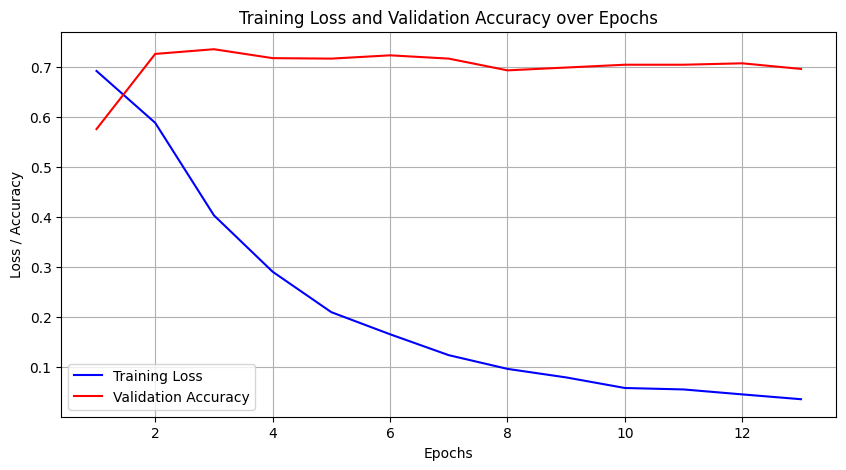

In [26]:
plot_loss_accuracy(losses, accuracies)

In [27]:
attn_tst_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7533


# Results

In [28]:
print(f"Last State Test Accuracy:       {last_tst_accuracy:.4f}")
print(f"Mean Pool Test Accuracy:        {mean_tst_accuracy:.4f}")
print(f"Max Pool Test Accuracy:         {max_tst_accuracy:.4f}")
print(f"Mean Max Pool Test Accuracy:    {mean_max_tst_accuracy:.4f}")
print(f"Attention Test Accuracy:        {attn_tst_accuracy:.4f}")

Last State Test Accuracy:       0.7477
Mean Pool Test Accuracy:        0.7383
Max Pool Test Accuracy:         0.7373
Mean Max Pool Test Accuracy:    0.7364
Attention Test Accuracy:        0.7533


From the above results, it is evident that implementing the OOV mitigation solution from Part 1 has improved the accuracy of the models

| Model Type | Part 3.1 Accuracy | Part 3.2 Accuracy |
| --- | --- | --- |
| Last State | 0.7158 | 0.7477 |
| Mean Pooling | 0.7073 | 0.7383 |
| Max Pooling | 0.7251 | 0.7373 |
| Mean Max Pooling | 0.448 | 0.7364 |
| Attention | 0.7083 | 0.7533 |